In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools
import sklearn.metrics as metrics
import itertools
from time import time

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\pmdarima\__init__.py:107: UserWarning: pmdarima support for 32-bit systems is ending with Python 3.10.Your system is not guaranteed to work going forward
  _warnings.warn(


## Datenbank einbinden
* Temperatursensor 1

In [2]:
connection = sql.connect("gcs_gh_10012022.db")

query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

In [3]:
df_temp1 = df_temp1.sort_index().loc['2021-08-20':'2021-08-31']

## Ausreißer behandeln
https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a
https://github.com/kdrelczuk/medium/blob/master/anomalies_local.py#L37

In [4]:
column = df_temp1['value']

k = int(len(column) * (0.15/100))
N = len(column)
print("Window size: ", k)
print("Datapoints: ", N)

time = np.arange(0,N)
column = column.to_numpy()

get_bands = lambda df_temp1 : (np.mean(df_temp1) + 3*np.std(df_temp1), np.mean(df_temp1) - 3*np.std(df_temp1))

Window size:  4
Datapoints:  3277


In [5]:
bands = [get_bands(column[range(0 if i - k < 0 else i-k ,i + k if i + k < N else N)]) for i in range(0,N)]
upper, lower = zip(*bands)

In [6]:
anomalies = (df_temp1['value'] > upper) | (df_temp1['value'] < lower)

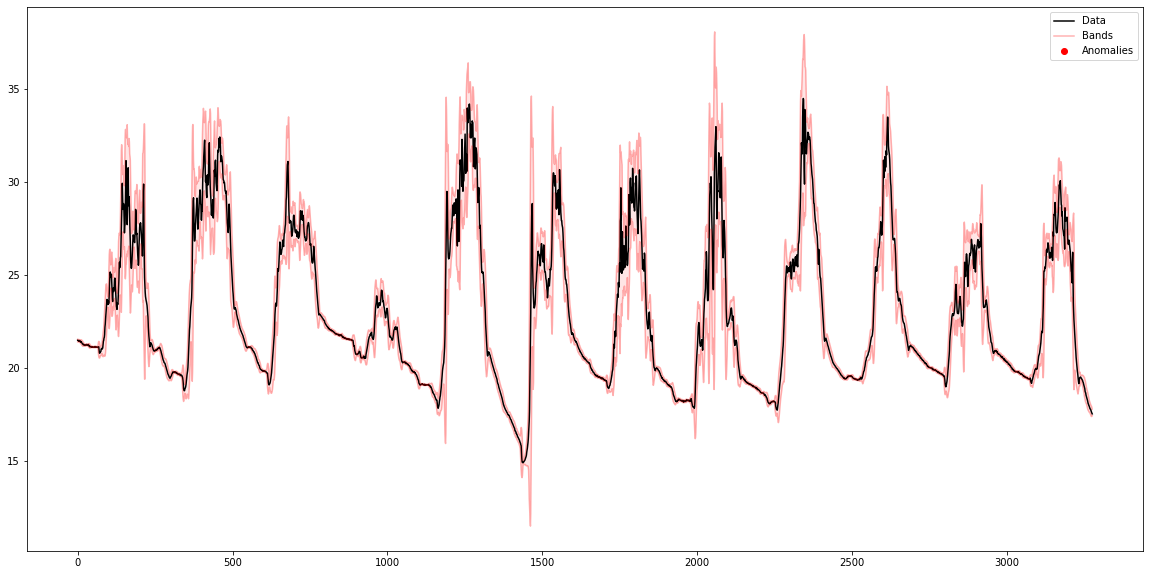

In [7]:
plt.figure(figsize=(20,10))
plt.plot(time,column,'k',label='Data')
plt.plot(time,upper,'r-',label='Bands',alpha=0.3)
plt.plot(time,lower,'r-',alpha=0.3)

plt.plot(time[anomalies],column[anomalies],'ro',label='Anomalies')
plt.fill_between(time, upper, lower,facecolor='red',alpha=0.1)
plt.legend()

## Datenlücken, duplizierte Indices behandeln

In [8]:
# prüfen ob doppelte Index-Werte (Timestamp) vorhanden 
print('TS has duplicates:', df_temp1.index.has_duplicates)
print('TS has NaN:', df_temp1['value'].isna().any())

# dopplte Index-Werte der Ausgangszeitreihe anzeigen 
df_temp1_duplicates = df_temp1[df_temp1.index.duplicated()]
print(df_temp1_duplicates)
print()

# Zeitreihe nach Behandlung der Indizes und Lücken durch Zusammenfassen anzeigen
df_temp1_5min = df_temp1.resample('5Min').mean()
print('TS 5min Intervals has duplicates:', df_temp1_5min.index.has_duplicates)
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

## Zeiträume sehen, in denen keine Daten vorhanden sind und durch das Zusammenfassen zu NaN werden
# print(df_temp1_5min.head(60))
# print(df_temp1.head(60))

TS has duplicates: True
TS has NaN: False
                        value
timestamp                    
2021-08-24 03:06:16  19.06386
2021-08-24 03:06:16  19.07721
2021-08-24 03:06:16  19.09057
2021-08-24 03:06:16  19.07721

TS 5min Intervals has duplicates: False
TS 5min Intervals has NaN: True


In [9]:
df_temp1_5min = df_temp1_5min.fillna(method='ffill')
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

TS 5min Intervals has NaN: False


## Daten zusammenfassen

In [10]:
df_temp1_hourly = df_temp1_5min.resample('H').mean()

## Stationarität

### Prüfen der Stationarität

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Daily mean GWH Temperature')]

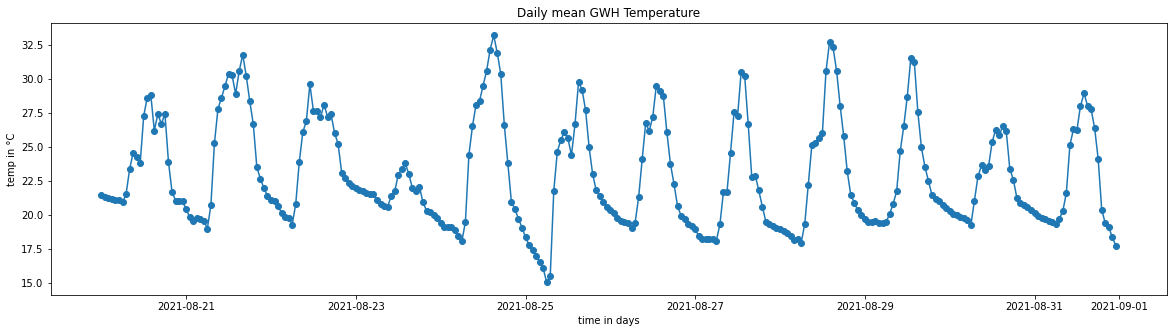

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.plot(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",                                                                                                                             
       title="Daily mean GWH Temperature")

In [12]:
series = df_temp1_hourly['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.308020630393367
p-value: 3.8562431296871696e-13
Critial Values:
   1%, -3.4538376962008495
Critial Values:
   5%, -2.8718811911083093
Critial Values:
   10%, -2.5722803076202174


Da (p-Wert) 0.0003 < (p-Wert Schwelle) 0.05 , wird die Nullhyppthese abgelehnt. Die Zeitreihe ist stationär. <br>

## Stationarität herstellen

### Saisonalität entfernen

Die Zeitreihe ist nach dem ADF-Test zwar stationär, allerdings scheint noch eine Saisonalität vorzuliegen. Da angenommen wird, dass sich die Temperatur im Tagesrhythmus verändert, wird die Differenz von 24 gebildet. d.h. die Zeitreihe wird mit ihrer, um 24h verschobenen, Zeitreihe abgezogen. Um die Varianzen zu reduzieren wird das Ergbnis nochmal um 1 differenziert.

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

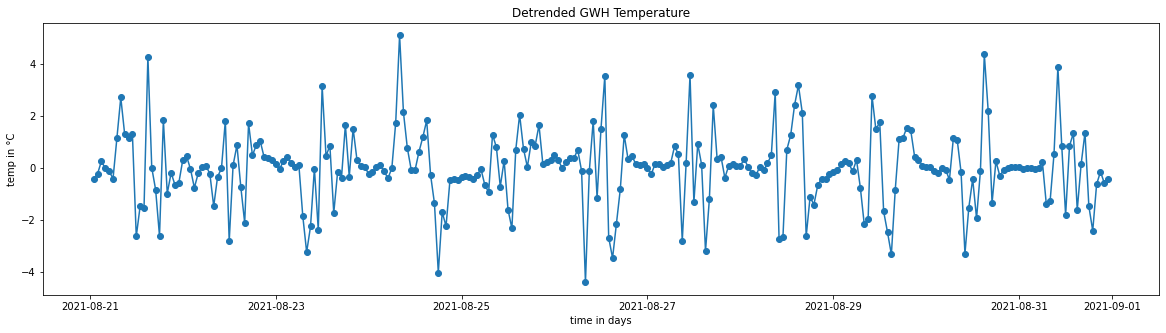

In [13]:
series_temp1_stationary_diff = df_temp1_hourly['value'].diff(periods=24)
series_temp1_stationary_diff = series_temp1_stationary_diff - series_temp1_stationary_diff.shift(1)
df_temp1_stationary = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_stationary.columns.values[0] = "value"

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.scatter(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [14]:
df_temp1_stationary = df_temp1_stationary.fillna(method='ffill').dropna()

series = df_temp1_stationary
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.155314768767172
p-value: 7.392879436913489e-08
Critial Values:
   1%, -3.457215237265747
Critial Values:
   5%, -2.873361841566324
Critial Values:
   10%, -2.5730700760129555


## Autocorrelation

### ACF

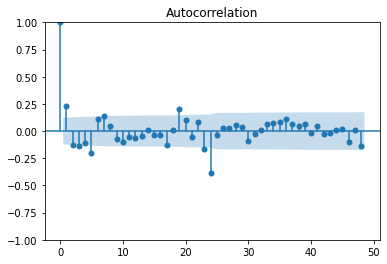

In [15]:
acf_result = stattools.acf(df_temp1_stationary)
acf_plot_temp1_hourly = tsaplots.plot_acf(df_temp1_stationary, lags=48)

### PACF

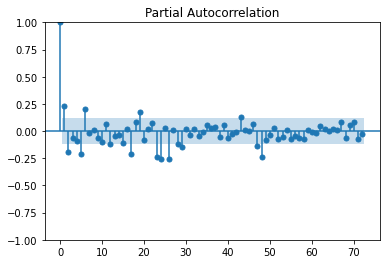

In [16]:
pacf_plot_temp1_hourly = tsaplots.plot_pacf(df_temp1_stationary,  method='ywm', lags=72)

## Daten splitten

In [17]:
# Frequenz der Zeitreihe wird festgelegt
df_temp1_modelling_data = df_temp1_hourly.asfreq(pd.infer_freq(df_temp1_hourly.index))

In [31]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_data = df_temp1_modelling_data.sort_index().loc['2021-08-20':'2021-08-28']
test_data = df_temp1_modelling_data.sort_index().loc['2021-08-29':'2021-08-31']

In [19]:
# Prediction Start und Ende festlegen
pred_start = test_data.index[0]
pred_end =test_data.index[-1]

# SARIMA

## Gridsearch

In [22]:
p = range(0,4)
d = {0}
q = range(0,4)
pdq = list(itertools.product(p,d,q)) # alle Kombis von p,d,q
p2 = range(0,3)
d2 = range(0,1)
q2 = range(0,3)
pdq2 = list(itertools.product(p2,d2,q2))
s = 24 # Zykluslänge
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2] # alle Kombis von p,d,q
combs = {}
aics = []

In [23]:
# Für jede Modellkombination ein SARIMA-Modell anlernen
for combination in pdq:
    for seasonal_combination in pdqs2:
        
        model = SARIMAX(train_data, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
        model = model.fit(disp=False)
        combs.update({model.aic : [combination, seasonal_combination]})
        aics.append(model.aic)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Usi

In [24]:
best_aic = min(aics)
print('best aic: ', round(best_aic, 3))
print(14*'==')
print ('ARIMA parameters: (', combs[best_aic][0][0], ',', combs[best_aic][0][1],',', combs[best_aic][0][2],')')
print('Seasonal parameters:', combs[best_aic][1])

best aic:  675.322
ARIMA parameters: ( 3 , 0 , 2 )
Seasonal parameters: (2, 0, 2, 24)


### SARIMA

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average

Mean absolute error (MAE):  1.1257142171797683
Mean squared error (MSE):  1.9433353453275555
Root Mean sqaured error (RMSE):  1.3940356327323757


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  216
Model:             SARIMAX(3, 0, 2)x(2, 0, 2, 24)   Log Likelihood                -327.661
Date:                            Sun, 03 Jul 2022   AIC                            675.322
Time:                                    21:11:36   BIC                            709.075
Sample:                                08-20-2021   HQIC                           688.959
                                     - 08-28-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1370      0.068     -2.025      0.043      -0.270      -0.004
ar.L2          0.4935      0.067      7.314      0.000       0.361       0.626
ar.L3          0.5991      0.073      8.155      0.000       0.455       0.743
ma.L1          1.4269      0.053     26.955      0.000       1.323       1.531
ma.L2          0.8884      0.045     19.941      0.000       0.801       0.976
ar.S.L24       0.3585      0.178      2.012      0.044       0.009       0.708
ar.S.L48       0.6369      0.153      4.151      0.000       0.336       0.938
ma.S.L24       0.0600      5.152      0.012      0.991     -10.038      10.159
ma.S.L48      -0.9332      4.590     -0.203      0.839      -9.930       8.064
sigma2         0.8853      4.270      0.207      0.836      -7.483       9.254
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                26.67
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.32
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

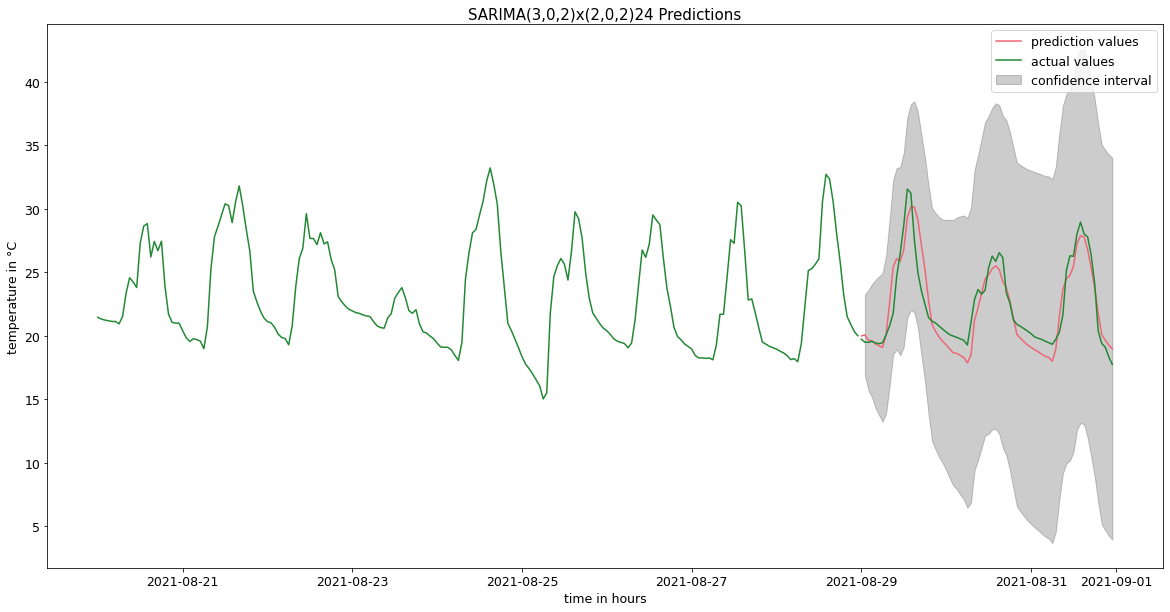

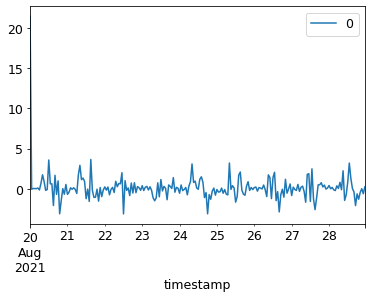

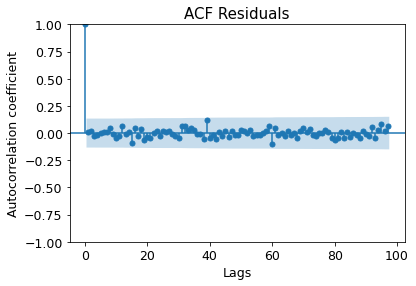

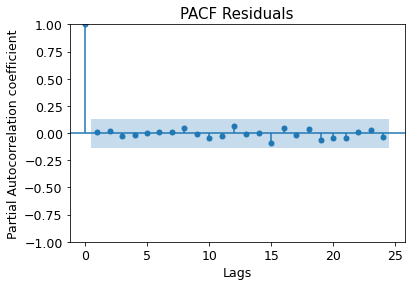

In [43]:
model = SARIMAX(train_data, order=(3,0,2), seasonal_order=(2,0,2,24))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='SARIMA(3,0,2)x(2,0,2)24 Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2, label='confidence interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient") 

model_fit.summary()

## Ausprobieren

Mean absolute error (MAE):  1.1690584058074873
Mean squared error (MSE):  2.1356465889525884
Root Mean sqaured error (RMSE):  1.4613851610552875


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  216
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood                -306.293
Date:                              Sun, 03 Jul 2022   AIC                            618.586
Time:                                      21:14:55   BIC                            628.343
Sample:                                  08-20-2021   HQIC                           622.538
                                       - 08-28-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1844      0.057      3.261      0.001       0.074       0.295
ma.S.L24      -0.7642      0.064    -11.978      0.000      -0.889      -0.639
sigma2         1.2969      0.097     13.428      0.000       1.108       1.486
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                36.28
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.05
Prob(H) (two-sided):                  0.75   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

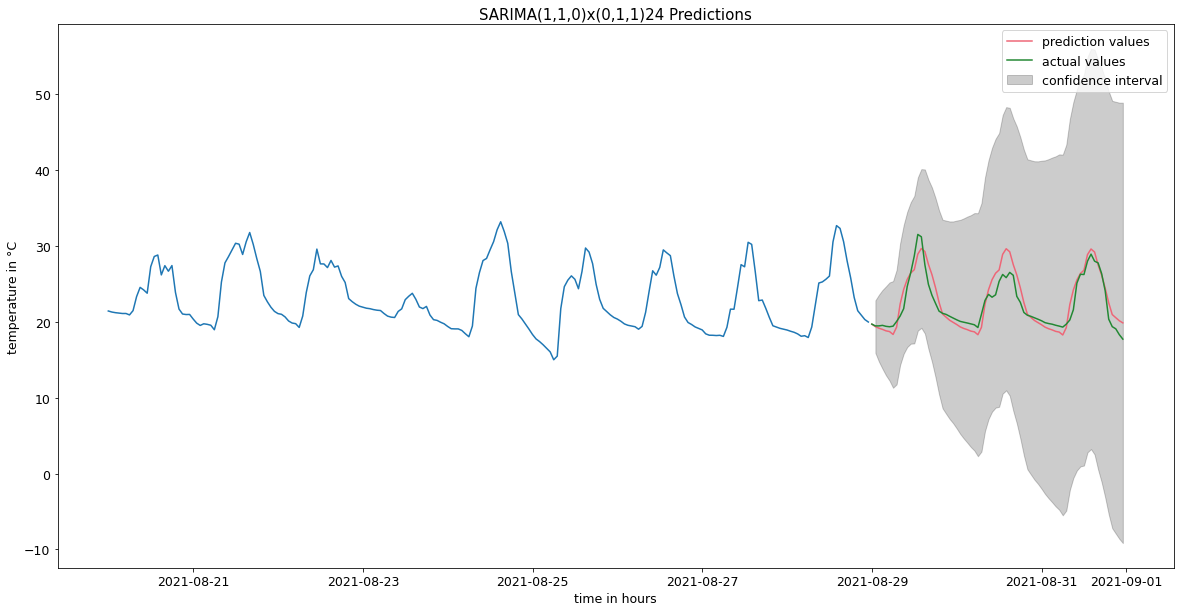

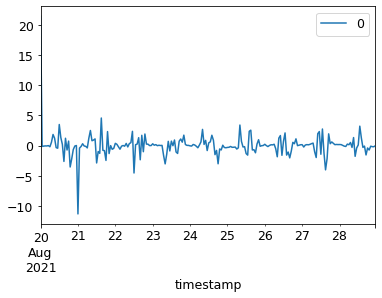

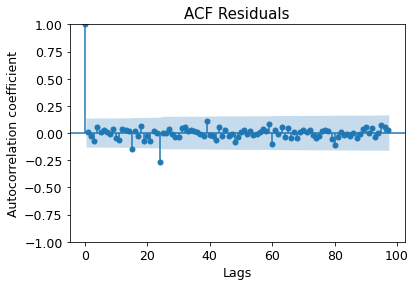

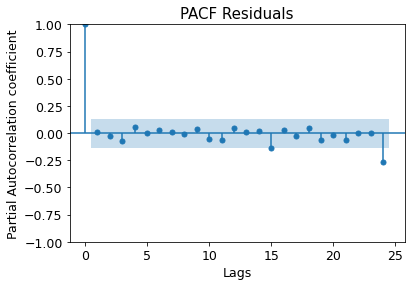

In [44]:
model = SARIMAX(train_data, order=(1,1,0), seasonal_order=(0,1,1,24))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='SARIMA(1,1,0)x(0,1,1)24 Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data)
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2, label='confidence interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient") 

model_fit.summary()

Mean absolute error (MAE):  1.7489662644130382
Mean squared error (MSE):  5.831489350141964
Root Mean sqaured error (RMSE):  2.4148476867376054


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  216
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 24)   Log Likelihood                -333.979
Date:                            Sun, 03 Jul 2022   AIC                            671.959
Time:                                    21:15:06   BIC                            678.474
Sample:                                08-20-2021   HQIC                           674.598
                                     - 08-28-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8908      0.027     32.468      0.000       0.837       0.945
sigma2         1.8830      0.144     13.042      0.000       1.600       2.166
===================================================================================
Ljung-Box (L1) (Q):                  11.43   Jarque-Bera (JB):                20.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.20
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

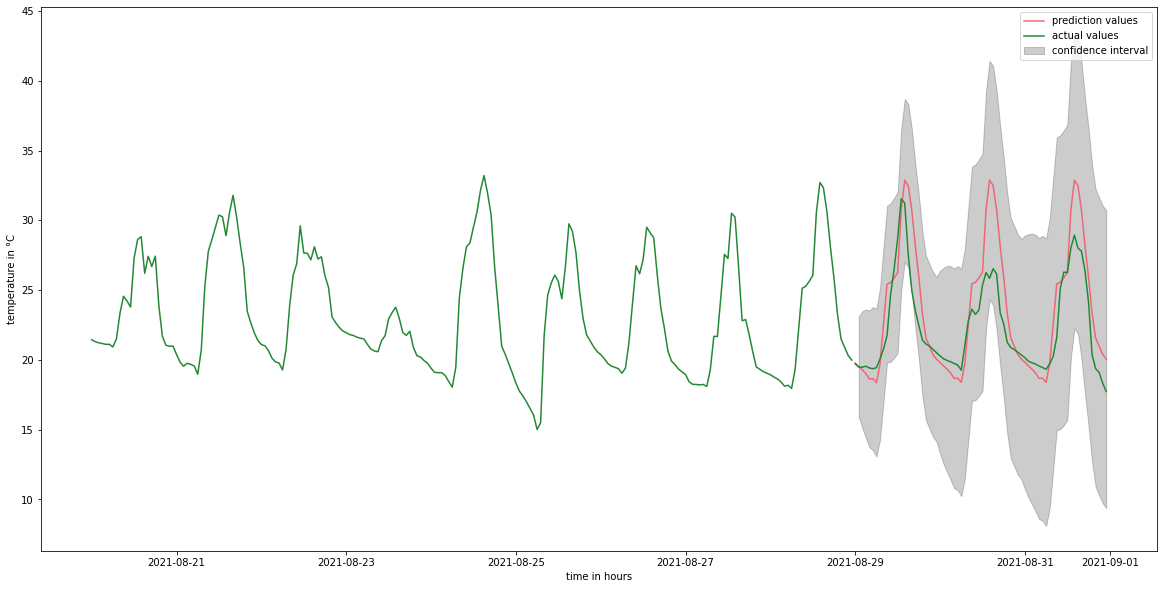

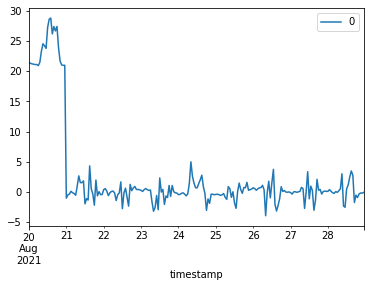

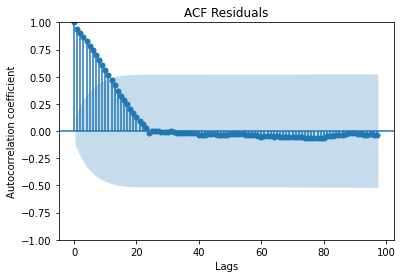

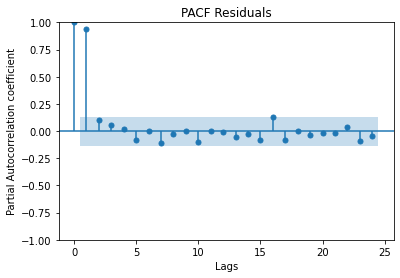

In [45]:
model = SARIMAX(train_data, order=(1,0,0), seasonal_order=(0,1,0,24))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,10))
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2, label='confidence interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient") 

model_fit.summary()